# Why run locally?

1. privacy - we have no way to verify that data we send to the API's is not collected
2. useful in offline situations

## Local speech - to - text

as of 2023, [Whisper](https://openai.com/research/whisper) remains the best open source (and free) speech to text model

OpenAI has provided a simple package to help with running their model 

https://github.com/openai/whisper

However it is rather slow because it runs on not so efficient for this kind of task PyTorch

As an alternative I can recommend this package:

https://github.com/guillaumekln/faster-whisper

It uses different backend - [CTranslate2](https://github.com/OpenNMT/CTranslate2/#key-features)





In [1]:
%pip install pytube --quiet
%pip install faster-whisper --quiet

Note: you may need to restart the kernel to use updated packages.


DEPRECATION: Loading egg at c:\users\kryst\appdata\local\programs\python\python311\lib\site-packages\wordcloud-1.8.2.post4+g5dd8d3e-py3.11-win-amd64.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330


Note: you may need to restart the kernel to use updated packages.


DEPRECATION: Loading egg at c:\users\kryst\appdata\local\programs\python\python311\lib\site-packages\wordcloud-1.8.2.post4+g5dd8d3e-py3.11-win-amd64.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330


In [8]:
# lets download the video
from pytube import YouTube

YouTube("https://www.youtube.com/watch?v=dQw4w9WgXcQ").streams.filter(only_audio=True)[0].download(output_path=".", filename="rick.mp3")


'c:\\Users\\kryst\\Documents\\PIMPS\\tutorials\\.\\rick.mp3'

In [2]:
import faster_whisper

model = faster_whisper.WhisperModel("small.en", compute_type="float32", device="cpu")


What models are available?

Any whisper model compatible with transformers library https://github.com/guillaumekln/faster-whisper#model-conversion

Here are models that are already quantized https://huggingface.co/collections/guillaumekln/faster-whisper-64f9c349b3115b4f51434976

For Polish you could probably use one of these https://huggingface.co/models?sort=trending&search=whisper+pl

But keep in mind that original Whisper is multilingual! It is of course not as good as English but might be useful.

In [8]:
segments, info = model.transcribe("rick.mp3")

In [4]:
info

TranscriptionInfo(language='en', language_probability=1, duration=212.1839375, duration_after_vad=212.1839375, all_language_probs=None, transcription_options=TranscriptionOptions(beam_size=5, best_of=5, patience=1, length_penalty=1, repetition_penalty=1, no_repeat_ngram_size=0, log_prob_threshold=-1.0, no_speech_threshold=0.6, compression_ratio_threshold=2.4, condition_on_previous_text=True, prompt_reset_on_temperature=0.5, temperatures=[0.0, 0.2, 0.4, 0.6, 0.8, 1.0], initial_prompt=None, prefix=None, suppress_blank=True, suppress_tokens=[-1], without_timestamps=False, max_initial_timestamp=1.0, word_timestamps=False, prepend_punctuations='"\'“¿([{-', append_punctuations='"\'.。,，!！?？:：”)]}、'), vad_options=None)

In [9]:
segments = list(segments)
for segment in segments:
    print("[%.2fs -> %.2fs] %s" % (segment.start, segment.end, segment.text))

[0.00s -> 27.00s]  We're no strangers to love You know the rules, and so do I
[27.00s -> 35.00s]  I feel commitments when I'm thinking of You wouldn't get this from any other guy
[35.00s -> 43.00s]  I just wanna tell you how I'm feeling Gotta make you understand
[43.00s -> 47.00s]  Never gonna give you up Never gonna let you down
[47.00s -> 53.00s]  Never gonna run around and desert you Never gonna make you cry
[53.00s -> 60.00s]  Never gonna say goodbye Never gonna tell a lie and hurt you
[60.00s -> 67.00s]  We've known each other for so long Your heart's been aching us
[67.00s -> 73.00s]  You're too shy to say it Inside we both know what's been going on
[73.00s -> 82.00s]  We know the game and we're gonna play it And if you ask me how I'm feeling
[82.00s -> 87.00s]  Don't tell me you're too blind to see Never gonna give you up
[87.00s -> 93.00s]  Never gonna let you down Never gonna run around and desert you
[93.00s -> 98.00s]  Never gonna make you cry Never gonna say goodbye
[98.00s

This is nice but let's convert it into a common standard - srt

In [6]:
%pip install srt --quiet

Note: you may need to restart the kernel to use updated packages.


DEPRECATION: Loading egg at c:\users\kryst\appdata\local\programs\python\python311\lib\site-packages\wordcloud-1.8.2.post4+g5dd8d3e-py3.11-win-amd64.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330


In [10]:
import srt

subtitles = []

for segment in segments:

    subtitles.append(srt.Subtitle(
        index=len(subtitles) + 1,
        start=srt.timedelta(seconds=segment.start),
        end=srt.timedelta(seconds=segment.end),
        content=segment.text
    ))

with open("rick.srt", "w") as f:
    f.write(srt.compose(subtitles))

For transcribing on edge I would recommend https://github.com/ggerganov/whisper.cpp but I will not go into detail

## Local LLMS

Note: LLM's are big

1B parameters = approx. 1GB RAM

Check your memory constraints on the device you are using


For model inference on CPU's I will use [llama.cpp](https://github.com/ggerganov/llama.cpp)

### Prerequisities

Installation - https://github.com/ggerganov/llama.cpp/releases

There are also docker images available


#### Models

all compatible models are available here : https://huggingface.co/models?search=gguf

If you find one that you want to test out just download the file in Files and versions section

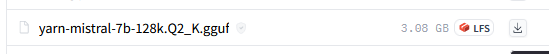

My personal recommendations:

https://huggingface.co/TheBloke/vicuna-7B-v1.5-GGUF


Once you have all the files ready, for simplicity we will start with server implementation

Run server.exe from the llama.cpp package you downloaded

In the terminal, replace path with appropriate model 

./server.exe -m vicuna-7b-v1.5.Q4_K_M.gguf

In [11]:
import requests

prompt = "Hey can you help me with something?"
data_json = { "prompt": prompt, "temperature": 0.1, "n_predict": 512, "stream": False }

resp = requests.post(
    url="http://127.0.0.1:8080/completion",
    headers={"Content-Type": "application/json"},
    json=data_json,
)
result = resp.json()["content"]

print(f"Prompt: {prompt}")
print(f"Result: {result}\n")

Prompt: Hey can you help me with something?
Result:  I'm trying to write a script that will allow users to upload files and then process them using some custom code. nobody knows what the file is or its contents, just the file name and extension. Is there any way to do this in python without having to manually parse the file for each user?

Ideally I would like to be able to run a script on the uploaded files that will extract specific information from them (like the number of lines, words, characters, etc) and then store that information in a database.

Is there any library or package that can help me with this task?



Here we have set the following parameters:

- temperature - it controls randomness in generations
- n_predict - number of tokens at which generation will terminate

Now let's try to make LLM do some work for us

In [13]:
def evaluate_prompt(prompt):
    data_json = { "prompt": prompt, "temperature": 0.1, "n_predict": 512, "stream": False }

    resp = requests.post(
        url="http://127.0.0.1:8080/completion",
        headers={"Content-Type": "application/json"},
        json=data_json,
    )
    result = resp.json()["content"]
    return result

passages = [
    """The Commission is of the opinion that  a given AI application should generally be considered high -risk 
in light of what is at stake, considering whether both the sector and the intended  use involve 
significant risks , in particular from the viewpoint of protection of safety , con sumer rights  and 
fundamental rights .""",
    """The Commission is of the opinion that the legislative framework could be improved to address  the 
following risks and situations : 
 Effective application and enforcement of existing EU and national legislation : the key 
characteristics of AI create challenges for ensuring the proper application and enforcement of 
EU and national legislation.""",
    """Their development 
and functioning must be such to ensure that AI systems behave reliably as intended.All reasonable 
measures should be taken to minimise the risk of harm being caused."""]

def create_prompt(task, passages):
    prompt = f"Task: {task}\n\n"
    prompt += "\n\n".join([f"Passage: {passage}\n" for passage in passages])
    prompt += "\n\nAnswer: "
    return prompt

prompt = create_prompt("Summarize Commission's stance on AI from the following passages", passages)

print(prompt)

Task: Summarize Commission's stance on AI from the following passages

Passage: The Commission is of the opinion that  a given AI application should generally be considered high -risk 
in light of what is at stake, considering whether both the sector and the intended  use involve 
significant risks , in particular from the viewpoint of protection of safety , con sumer rights  and 
fundamental rights .


Passage: The Commission is of the opinion that the legislative framework could be improved to address  the 
following risks and situations : 
 Effective application and enforcement of existing EU and national legislation : the key 
characteristics of AI create challenges for ensuring the proper application and enforcement of 
EU and national legislation.


Passage: Their development 
and functioning must be such to ensure that AI systems behave reliably as intended.All reasonable 
measures should be taken to minimise the risk of harm being caused.


Answer: 


In [14]:
evaluate_prompt(prompt)

" The Commission's stance on AI is that it considers high-risk applications to be those that involve significant risks, particularly in terms of safety, consumer rights, and fundamental rights. It believes that the legislative framework needs to be improved to address the challenges posed by AI systems, including ensuring effective application and enforcement of existing laws. The Commission also emphasizes the importance of developing and deploying AI systems that are reliable and minimize the risk of harm."

Language models are good at tasks related to language

If we use them to answer questions specific to a domain without providing context or use them for reasoning we will fail.

In [15]:
evaluate_prompt("Summarize Commission's stance on AI from the following passages")

":\n nobody knows what it is, and there are no known ways to make it. It is a mystery that has puzzled scientists for decades. The Commission believes that AI is not something that can be created or controlled by humans. It is a force of nature, like electricity or gravity, that exists independently of human consciousness.\nThe Commission also believes that AI is not something that can be used for good or evil. It is simply a tool that can be used to achieve certain goals, whether those goals are noble or ignoble. The Commission sees AI as a neutral force that can be used for either positive or negative purposes, depending on how it is used.\nThe Commission's stance on AI is that it is a mystery that cannot be controlled by humans and that it has the potential to be used for both good and evil."

The model I'm using - Vicuna has context length of 4096

Let's see what happens if we exceed that number

In [16]:
url = r"https://raw.githubusercontent.com/ggerganov/llama.cpp/master/examples/server/README.md"

resp = requests.get(url)
text = resp.text

prompt = f"Task: What are the main features of the llama server?\n\nPassage: {text}\n\nAnswer: "

len(prompt)

16278

Here is a good explanation on what happens inside along with explanation on attention:

https://www.youtube.com/watch?v=f23sUViqxH8

As of november 2023 llama.cpp does not support these streaming models, but it supports caching which I will go into detail in next tutorial

In [17]:
evaluate_prompt(prompt)

'\n\nThis is a Python script that creates an API server using the OpenAPI specification (OAI). The OAI specifies how to build and document RESTful APIs. This script uses the `openapi3` library to generate the API documentation, and the `Flask` library to create the API server.\n\nThe script defines a single endpoint `/text_completion` that accepts a POST request with a JSON payload containing a `prompt` field and a `max_tokens` field. The `prompt` field is a string that contains the text for which the API should generate completions, and the `max_tokens` field is an integer that specifies the maximum number of tokens (words or symbols) to return in the completion.\n\nThe `/text_completion` endpoint uses the `llama` library to generate completions based on the provided prompt. The `llama` library is a CLI tool that can be used to generate text completions for any given input. It takes a JSON payload with a `prompt` field and returns a JSON response containing an array of completion sugg

It loses context, also generation time is very long because of recomputation

You can find more options for LLM server here:

https://github.com/ggerganov/llama.cpp/blob/master/examples/server/README.md

I encourage you to test out your own prompts, models etc. 

I will go into detail into sampling methods, prompt engineering next week